# Plant Species Identification

## Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.conv_learner import *

## Data Setup

### Create data object

In [3]:
CWD = os.getcwd()
PATH = 'data/plant_seedlings_classification'
label_csv = os.path.join(PATH, 'labels.csv')
sz = 224
arch = resnet34
bs = 64

### One time data wrangling

In [ ]:
# os.chdir(PATH)

In [ ]:
# train_path = os.path.join(os.getcwd(), 'train')

In [ ]:
# df = pd.DataFrame(columns=["file", "species"])

# os.chdir(train_path)
# for dir_ in os.listdir():
#     os.chdir(os.path.join(train_path, dir_))
#     dir_underscore = dir_.replace(' ', '_')
#     for img in glob('*.png'):
#         os.rename(img, '../'+img)
#         df = df.append({"file": img, "species": dir_underscore}, ignore_index=True)
#     os.chdir(train_path)
#     os.rmdir(dir_)
# os.chdir(CWD)
# df.to_csv(label_csv, index=False)

### Data Object

In [4]:
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)
n, len(val_idxs)

(4750, 950)

In [5]:
def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', label_csv, test_name='test',
                                        val_idxs=val_idxs, tfms=tfms, bs=bs)
    return data if sz > 300 else data.resize(340, 'tmp')

In [6]:
data = get_data(sz, bs)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

## Explore Data

### Pivot table

In [ ]:
label_df = pd.read_csv(label_csv)

In [ ]:
label_df.head()

In [ ]:
pvt = label_df.pivot_table(index='species', aggfunc=len).sort_values('file', ascending=False)

In [ ]:
pvt

### Visualize

In [ ]:
img = PIL.Image.open(os.path.join(PATH, data.trn_ds.fnames[0])); img

In [ ]:
img.size

### Histograms

In [ ]:
size_d = {k: PIL.Image.open(os.path.join(PATH,k)).size
          for k in data.trn_ds.fnames}

In [ ]:
row_sz, col_sz = map(np.array, list(zip(*size_d.values())))

In [ ]:
plt.hist(row_sz)

In [ ]:
plt.hist(row_sz[row_sz<1000])

In [ ]:
plt.hist(row_sz[row_sz<300])

In [ ]:
plt.hist(col_sz)

In [ ]:
plt.hist(col_sz[col_sz<1000])

## Image Classifier

### Create Learner

In [7]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

### Find Learning Rate

In [8]:
lrf = learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 67%|██████▋   | 40/60 [00:00<00:00, 42.32it/s, loss=11.6]


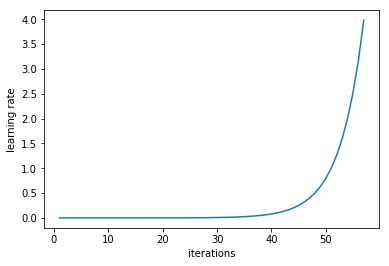

In [9]:
learn.sched.plot_lr()

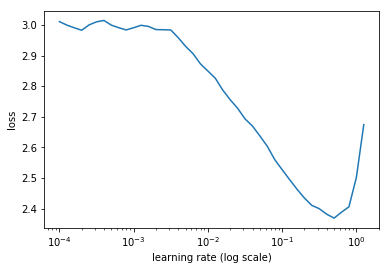

In [10]:
learn.sched.plot()

### Train the newly added final layer

In [ ]:
learn.fit(3e-2, n_cycle=3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.sched.plot_lr()

In [ ]:
learn.sched.plot_loss()

## Augmentation

In [11]:
learn.precompute = False
learn.unfreeze()

In [ ]:
lr = 3e-2

In [ ]:
learn.fit([lr/9, lr/3, lr], n_cycle=3, cycle_len=1, cycle_mult=2)

learn.save('resnet34')

In [12]:
learn.load('resnet34')

## Increase Size

In [13]:
learn.set_data(get_data(299,bs))

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [ ]:
lr = 1e-2

In [ ]:
learn.fit([lr/9, lr/3, lr], n_cycle=3, cycle_len=1, cycle_mult=2)

learn.save('resnet34_299')

In [14]:
learn.load('resnet34')

In [ ]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds), axis=0)
accuracy(probs, y)

## Test predictions

In [15]:
log_preds,y = learn.TTA(is_test=True)

In [16]:
log_preds.shape

(5, 794, 12)

In [17]:
y.shape

(794, 1)

In [18]:
probs = np.mean(np.exp(log_preds), axis=0)

## Submit to kaggle

In [19]:
preds = np.argmax(probs, axis=1)

In [55]:
def kaggle_submit(PATH, preds, data, sub_num):
    class_preds = [data.classes[x].replace('_', ' ') for x in preds]

    assert(len(class_preds) == len(data.test_ds.fnames))

    files = [x.split('/')[-1] for x in data.test_ds.fnames]

    df = pd.DataFrame(list(zip(files, class_preds)))
    df.columns = ['file', 'species']

    submit_folder = os.path.join(PATH, 'submit')
    submit_filepath = os.path.join(submit_folder, f'plant_submission{sub_num}.gz')
    os.makedirs(submit_folder, exist_ok=True)
    df.to_csv(submit_filepath, compression='gzip', index=False)
    return submit_filepath

In [56]:
FileLink(kaggle_submit(PATH, preds, data, '2'))

/home/paperspace/fastai/courses/dl1/data/plant_seedlings_classification/submit/plant_submission2.gz